<a href="https://colab.research.google.com/github/skatsushi/GNN_Sample/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
import matplotlib.pyplot as plt
import networkx as nx

import torchvision
import torchvision.transforms as transforms

from torch_geometric.utils import to_networkx # This import should work after installing the library.
from torch_geometric.data import Data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [4]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root="./MUTAG", name="MUTAG")
len(dataset) # => 188

Processing...
Done!


188

In [5]:
data = dataset[0]
print(data) #=> Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


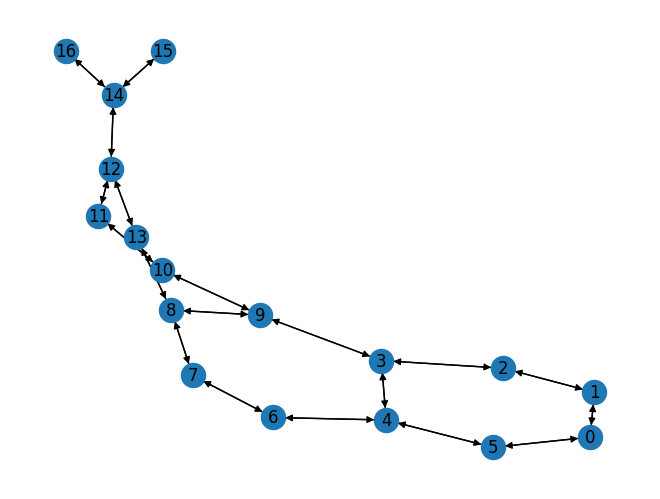

In [6]:
import networkx as nx
from torch_geometric.utils import to_networkx

nxg = to_networkx(data)
nx.draw(nxg, with_labels=True)

In [8]:
!pip install torch torchvision torchaudio
!pip install torch-geometric


In [9]:
# 必要なライブラリのインポート
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# デバイスの設定（GPUが利用可能ならGPUを使用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データセットの読み込み
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_node_features}')

# データセットの分割（80% トレーニング、20% テスト）
torch.manual_seed(42)
dataset = dataset.shuffle()
train_dataset = dataset[:int(0.8 * len(dataset))]
test_dataset = dataset[int(0.8 * len(dataset)):]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# GCNモデルの定義
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # グラフ畳み込み層1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # グラフ畳み込み層2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # グローバルプーリング
        x = global_mean_pool(x, batch)
        # 全結合層
        x = self.lin(x)
        return x

# モデルの初期化
model = GCN(num_node_features=dataset.num_node_features,
            hidden_channels=64,
            num_classes=dataset.num_classes).to(device)

# オプティマイザの設定
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# トレーニング関数
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# テスト関数
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# トレーニングの実行
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# 結果の表示
test_accuracy = test(test_loader)
print(f'最終テスト精度: {test_accuracy:.4f}')


Processing...
Done!


Number of graphs: 188
Number of classes: 2
Number of node features: 7
Epoch: 010, Loss: 0.4902, Train Acc: 0.7733, Test Acc: 0.6316
Epoch: 020, Loss: 0.4961, Train Acc: 0.7467, Test Acc: 0.6579
Epoch: 030, Loss: 0.4716, Train Acc: 0.7533, Test Acc: 0.6579
Epoch: 040, Loss: 0.4651, Train Acc: 0.7867, Test Acc: 0.6579
Epoch: 050, Loss: 0.4678, Train Acc: 0.7867, Test Acc: 0.6579
Epoch: 060, Loss: 0.4738, Train Acc: 0.7733, Test Acc: 0.6579
Epoch: 070, Loss: 0.4611, Train Acc: 0.7933, Test Acc: 0.6579
Epoch: 080, Loss: 0.4469, Train Acc: 0.7600, Test Acc: 0.6842
Epoch: 090, Loss: 0.4493, Train Acc: 0.7800, Test Acc: 0.6842
Epoch: 100, Loss: 0.4436, Train Acc: 0.7867, Test Acc: 0.6579
Epoch: 110, Loss: 0.4318, Train Acc: 0.8267, Test Acc: 0.7105
Epoch: 120, Loss: 0.4214, Train Acc: 0.8000, Test Acc: 0.7368
Epoch: 130, Loss: 0.4147, Train Acc: 0.8000, Test Acc: 0.7105
Epoch: 140, Loss: 0.4008, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 150, Loss: 0.3998, Train Acc: 0.8200, Test Acc: 0.7105
